In [1]:
import warnings
warnings.filterwarnings('ignore')

from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1)
mnist.keys()

dict_keys(['data', 'target', 'feature_names', 'DESCR', 'details', 'categories', 'url'])

In [2]:
# print('feature names: ', mnist['feature_names'])
print('DESCR: ', mnist['DESCR'])

DESCR:  **Author**: Yann LeCun, Corinna Cortes, Christopher J.C. Burges  
**Source**: [MNIST Website](http://yann.lecun.com/exdb/mnist/) - Date unknown  
**Please cite**:  

The MNIST database of handwritten digits with 784 features, raw data available at: http://yann.lecun.com/exdb/mnist/. It can be split in a training set of the first 60,000 examples, and a test set of 10,000 examples  

It is a subset of a larger set available from NIST. The digits have been size-normalized and centered in a fixed-size image. It is a good database for people who want to try learning techniques and pattern recognition methods on real-world data while spending minimal efforts on preprocessing and formatting. The original black and white (bilevel) images from NIST were size normalized to fit in a 20x20 pixel box while preserving their aspect ratio. The resulting images contain grey levels as a result of the anti-aliasing technique used by the normalization algorithm. the images were centered in a 28x28

In [3]:
X, y = mnist['data'], mnist['target']
print(X.shape)
print(y.shape)


(70000, 784)
(70000,)


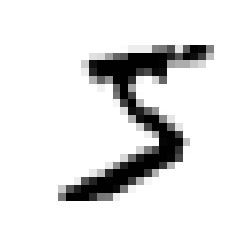

In [4]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

some_digit = X[0]
some_digit_image = some_digit.reshape(28,28)

plt.imshow(some_digit_image, cmap = mpl.cm.binary, interpolation='nearest')
plt.axis('off')
plt.show()

In [5]:
import numpy as np
y = y.astype(np.uint8)

In [6]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [7]:
y_train_5 = (y_train == 5)
print(y_train_5[:5])
y_test_5 = (y_test == 5)
print(y_test_5[:5])


[ True False False False False]
[False False False False False]


In [8]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=None,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=42, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False)

In [9]:
sgd_clf.predict([some_digit])

array([False])

In [10]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, random_state=42)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds =  X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_folds = X_train[test_index]
    y_test_folds = y_train_5[test_index]
    
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_folds)
    n_correct = sum(y_pred == y_test_folds)
    print(n_correct / len(y_pred))

0.9532
0.95125
0.9625


In [11]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.9532 , 0.95125, 0.9625 ])

In [12]:
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)
    

In [13]:
never_5 = Never5Classifier()
cross_val_score(never_5, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.91125, 0.90855, 0.90915])

In [14]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

Due to the over simplicity of the accuracy measurement, the confusion matrix is instead used as a measure of a classifier's efficacy. 

The confusion matrix is organized thusly:
Each row represents a /real/ class, while each column represents the class predicted.
Thus the value at row i, column j represents the number of instances of class i which were classified as class j by the predict function. 
A perfect classifier would then return a confusion matrix with only non-zero values along it's primary diagonal(Top Left to Bottom Right)


In [15]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)

array([[52992,  1587],
       [ 1074,  4347]], dtype=int64)

Precision is another metric which can be used to give a more concise version of the confusion matrix. 
Precision = (True-Positives)/(True-Positives + False-Positives) = TP/(TP + FP)

Precision is often examined in conjunction with Recall, also called 'sensitivity' or 'true positive rate'
Recall = (True-Positives)/(True-Positives + False-Negatives) = TP/(TP + FN)

In [16]:
from sklearn.metrics import precision_score, recall_score

print(precision_score(y_train_5, y_train_pred))

print(recall_score(y_train_5, y_train_pred))


0.7325581395348837
0.8018815716657444


The F_1 Score is the combination of recall and precision and is often used as a simple way to compare two classifiers. 
The F_1 Score is the harmonic mean of the recall and precision.

F_1 = 2/((1/precision) + (1/recall)) = 2 * (precision*recall)/(precision+recall) = TP/(TP+(FN + FP)/2)

In [17]:
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.765653896961691

A flaw in using the F_1 Score for evaluation is that it favors classifiers that have similar recall and precision. In some contexts one might be more significant than the other for your purposes, so a low F_1 score might be misleading. 

In some cases where false negatives are acceptable, but false positives are not, a classifier with high precision and low recall may be suitable. An example for this would be a filter for children's programming. Keeping False positives (videos unsuitable for children) minimal would be very important here, though it's fine if some good videos get flagged. 

Another example would be video surveillance to catch shoplifters. High Precision is less important, as it's ok if a security guard gets a false alert, but you want high recall, meaning few false negatives, so few shoplifters go un-caught.

In essence; 
Precision is representative of the rate at which positive predictions are correct
Recall is the percentage of possible positives that are identified as such

However in practice, a higher value in one leads to a lower value in the other. This is called precision/recall tradeoff. This can be seen via the precision/recall curve. 

In [18]:
from sklearn.metrics import precision_recall_curve

y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method='decision_function')

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)



Here we can see the comparison of the recall and precision curve lines. As is evident from examining this plot, maximization of both is not possible beyond their intersection point. In optimizing a classifier, one will have to be favored. 

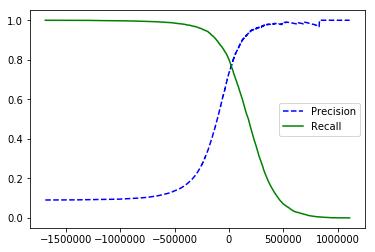

In [19]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], 'b--', label='Precision')
    plt.plot(thresholds, recalls[:-1], 'g-', label='Recall')
    
    plt.legend()
    
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

In [20]:
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]
y_train_pred_90 = (y_scores > threshold_90_precision)

print(precision_score(y_train_5, y_train_pred_90))
print(recall_score(y_train_5, y_train_pred_90))

0.9002493765586035
0.5993359158826784


Another tool with Binary Classifiers is the Receiver Operating Characteristic(ROC) curve. Instead of plotting precision vs recall as before, this curve plots the True Positive Rate(TPR or Recall) vs the False Positive Rate(FPR), or 1-True Negative Rate. The True Negative Rate(TNR), the number of negatives correctly classified as negative, is also called the Specificity. Thus the ROC curve plots Sensitivity, or Recall, against 1-Specificity, or 1-TNR

In [21]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0,1],[0,1], 'k--')
    plt.xlabel('False Positive Rate or FPR')
    plt.ylabel('Recall or TPR')

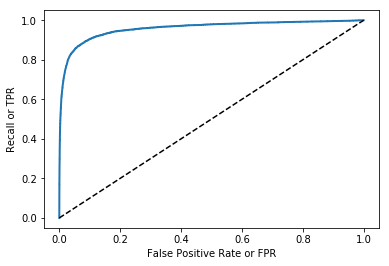

In [22]:
plot_roc_curve(fpr, tpr)
plt.show()

The dotted line here represents a random classifier, and a good one should stay away from this line, aiming for the upper left. One way to use the curve to compare classifiers is to measure the Area Under the Curve (AUC).

A random classifier would have an AUC Score of 0.5, and a perfect one will have a score of 1.

In [23]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5, y_scores)

0.9584692857783504

Because the Precision/Recall and Receiver Operating Characteristic curve are so similar, it is good to have a rule of thumb for which to use and when. In general, if the positive class is rare, or if false-positives are more concerning than false negatives, P/C curve is more suitable. Otherwise it is better to use the ROC Curve and the ROC AUC score.  

After using the SGD classifier for illustration of these metrics, it is good to compare it to another architecture: Random Forest Classifier. 

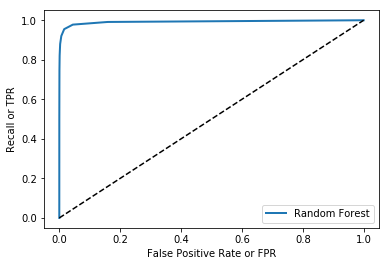

In [24]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)

y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method='predict_proba')

y_scores_forest = y_probas_forest[:, 1]
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)


plot_roc_curve(fpr_forest, tpr_forest, 'Random Forest')
plt.legend(loc='lower right')
plt.show()

In [25]:
roc_auc_score(y_train_5, y_scores_forest)

0.9920527492698306

Up to this point the classification has been binary. Is a given digit a 5 or not? But often in the real world we have to deal with situations requiring numerous classes. While there are other architectures specifically for handling multiple classification, binary classifiers can be repurposed and combined to form makeshift multi-classifiers. The two methods for this are One-versus-One (OvO) and One-versus-All (OvA).

One Versus One is where a series of binary classifiers distinguishing each class from each other class, one by one. This means that each class will have a series of classifiers distinguishing it from each other class. 

One Versus All is similar to the example we've been using above with 5. For each class, a single classifier determining whether or not the value is that class, is trained, and they are combined. 

Each of these methodologies then accumulates the results of each sub-classifier and by selecting the highest decision-score, selects the most likely class. 

When multi-Class training sets are introduced to a sci-kit learn model, the model automatically adapts and switches the classifier to OvA, except for SVM classifiers which use OvO.

Sci-Kit learn does allow for the imposition of OvO and OvA on models via the OneVsOneClassifier and OneVsRestClassifier classes. This is done simply by passing a binary classifier to the constructor of a new instance. 

In [26]:
from sklearn.multiclass import OneVsOneClassifier

ovo_clf = OneVsOneClassifier(SGDClassifier(random_state=42))
ovo_clf.fit(X_train, y_train)
ovo_clf.predict([some_digit])

array([5], dtype=uint8)

In [27]:
forest_clf.fit(X_train, y_train)
forest_clf.predict([some_digit])

array([5], dtype=uint8)

In [28]:
forest_clf.predict_proba([some_digit])

array([[0. , 0. , 0. , 0.2, 0. , 0.8, 0. , 0. , 0. , 0. ]])

In [29]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.86872625, 0.87639382, 0.87848177])

In [30]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3)

array([0.90736853, 0.90884544, 0.91363705])

In [31]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5726,    2,   26,   12,   11,   47,   47,    9,   39,    4],
       [   1, 6479,   42,   33,    8,   39,    8,    9,  113,   10],
       [  55,   35, 5319,  104,   79,   20,  106,   51,  174,   15],
       [  45,   40,  145, 5372,    3,  210,   33,   50,  135,   98],
       [  17,   26,   38,    8, 5361,    5,   57,   31,   86,  213],
       [  74,   38,   43,  199,   71, 4584,  116,   26,  175,   95],
       [  33,   22,   43,    2,   42,   90, 5640,    3,   43,    0],
       [  24,   23,   73,   29,   60,   12,    4, 5774,   18,  248],
       [  49,  165,   73,  150,   16,  153,   50,   24, 5038,  133],
       [  39,   31,   26,   92,  163,   35,    3,  177,   79, 5304]],
      dtype=int64)

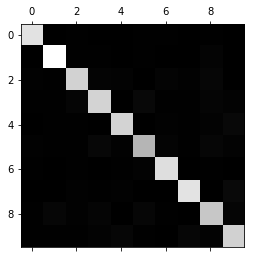

In [32]:
# Showing plain confusion matrix
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

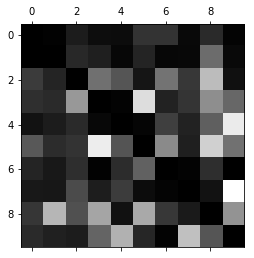

In [33]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

#Multi-Label Classification
Multilabel Classification is a classification system that outputs multiple binary tags. What this means is that a multilabel classifier can check for the presence of multiple desired classes simultaneously within a single prediction



In [34]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn = KNeighborsClassifier()
knn.fit(X_train, y_multilabel)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform')

In [35]:
knn.predict([some_digit])

array([[False,  True]])

Multi-Ouptut Classification is a generalization of multi-label classification. Multi-Output Classification is when each one of the multiple labels being classified, can have multiple values beyond just True or False. 

In [36]:
noise = np.random.randint(0, 100, len(X_train, 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, len(X_test, 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

TypeError: len() takes exactly one argument (2 given)

In [ ]:
knn.fit(X_train_mod, y_train_mod)
clean_digit = knn.predict([X_test_mod[some_index]])
clean_digit.reshape(28,28)
plt.imshow(clean_digit, cmap = mpl.cm.binary, interpolation='nearest')
plt.axis('off')
plt.show()